In [15]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [16]:
path = Config().data_path()/'mnist'

In [17]:
path.ls()

[WindowsPath('C:/Users/kting/.fastai/data/mnist/mnist.pkl.gz')]

In [18]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
# The underscore, '_', is actually referring to the test set. Here, we don't care about it, so we give it an underscore.

In [19]:
x_train.shape

(50000, 784)

Note `x_train`'s shape. `50000` refers to the number of digits (test examples). 784 is the number of pixels per digit.

Interestingly, the MNIST images (along with their labels, y) that we downloaded are stored in a `numpy`-array format, instead of actual images (like jpg) that one might expect. You should be able to deduce anyway, when we download the .pickle file. Pickle files are just `numpy` arrays. 

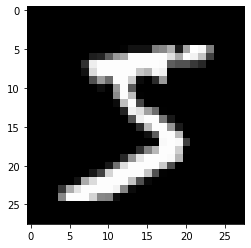

In [20]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray") # reshaped to 28x28 square to plot. But anyway, we'll be using it flat.

In [21]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid)) # convert them to tensors
n,c = x_train.shape # n,c = 50000, 784
y_train.min(), y_train.max() # Just to show that the labels are digits. 0 to 9.

(tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [22]:
bs=64
# A TensorDataset is something which you can index into, and obtain a x value and its corresponding y.
train_ds = TensorDataset(x_train, y_train) 
valid_ds = TensorDataset(x_valid, y_valid)

# We create a DataBunch called data. Looking at the src code, it basically shuffles the train and valid ds, and loads stuff into GPU.
data = DataBunch.create(train_ds, valid_ds, bs=bs) 

In [27]:
doc(DataBunch.create)

In [26]:
# We obtain the DataLoader from the DataBunch. It's like a generator. Calling next() on the dl returns the next batch
# of size bs. We can verify that a batch of the correct size is returned below.
x,y = next(iter(data.train_dl)) 
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [30]:
# Basically extending the nn.Module class.

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__() # Inheriting the superclass constructor.
        self.lin = nn.Linear(784, 10, bias=True) # Create a new attribute that stores a 'Linear' module. 
        # It does the a@x + b. See `def forward`.

    def forward(self, xb): 
        return self.lin(xb) # The nn.linear instantiation somehow becomes a function that returns the linear product. Somehow.
    # 'xb' refers to the mini-batch of x. Which a bs-sized of training examples (e.g. 32, 64 of these images). 

So this is a logistic regression model. A logistic regression model is also known as a neural net with no hidden layers, so it's a one layer neural net, no nonlinearities.

Because we're doing stuff ourself a little bit we have to put the weight matrices (i.e. the parameters) onto the GPU manually. So just type `.cuda()` to do that.

In [31]:
model = Mnist_Logistic().cuda()

In [32]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [33]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [34]:
model(x).shape

torch.Size([64, 10])

In [35]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

`out_features` is 10. That's the `[10, 784]`. Recall that our model, given a test example of 1D vector of size 784, through the weight matrix, is to spit out a 1D vector of size 10. This represents the probability distribution of the digits from 0-9.

It should make sense that the weight matrix should be of size 10-by-784.

`Weight * x = prediction - > [10, 784] * [784, 1] = [10, 1]`

__I have been ommiting the biases. The full expression conveyed in the previous cell should be:__

`Weight * x + biases = prediction -> [10, 784] * [784, 1] + [10, 1] = [10, 1]`

For loss function, it does not make sense to use MSE because the prediction is categorical. To give an example, let's say target = 3, and prediction = 4. Using MSE would be like saying that your model's prediction is close, since it's only 1 number away. And whereas if you had predicted 9 instead, then your loss would be higher. Which as said, does not make sense because a wrong guess is a wrong guess, no matter how close your prediction is to the actual target. So that's why we have to consider the model's prediction's probability distribution instead, which is Cross Entropy Loss.

In [37]:
loss_func = nn.CrossEntropyLoss()

In [43]:
def update(x,y,lr):
    # Given a batch of training examples, and lr, compute the loss' gradient, to update the parameters. And return the loss value.
    # To understand this function, it helps to work through with ONE training example in mind, rather than a batch of them.
    
    # Weight decay
    wd = 1e-5
    
    # Prediction
    y_hat = model(x) # Somehow (again), you can treat your model as a function that can take in x and returns the prediction.
    
    # weight squared. Sum of all weights squared. Will be multiplied by wd. This is for regularisation. Which is to avoid overfitting.
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
        
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    
    # Calculate the gradient of the loss function.
    loss.backward()
    
    with torch.no_grad(): # Basically, call torch.no_grad()
        for p in model.parameters(): # for each parameter of ALL parameters, perform the following:
            p.sub_(lr * p.grad) # Gradient descent. Subtraction is performed inplace.
            p.grad.zero_()
    return loss.item() # return a normal python number.

In [39]:
lr=2e-2
losses = [update(x,y,lr) for x,y in data.train_dl]

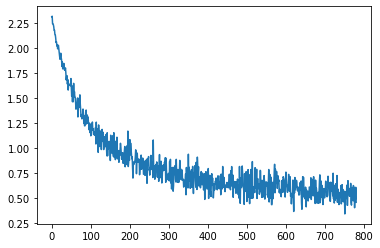

In [42]:
plt.plot(losses);

__Interesting things of note from above graph:__

1. The x-axis represents the number of batches processed thus far. Recall in each batch, the no. of training examples in it is 64. `update()` works on one batch at a time, following which updates the parameters on the model, for subsequent batches. The loss value should thus drop, as it did above. Essentially, what we did was one epoch. The model only sees each training example _once_.

2. Notice that the loss value flucutates more and more wildly towards the end. As the training converges to some minima, you can imagine the space as becoming more and more flat, and thus each gradient descent step makes the same-sized step towards the negative gradient direction (since `lr` is fixed), but since the space is already quite flat so it overshoots the actual minima often. By right, `lr` should decrease as we converge (**learning rate annealing**), but since it didn't, so it will spend steps every now and then to correct itself, resulting in this back-and-forth of loss value.

## Before it's logistic regression, now it's neural network - add one more layer

### Basic SGD

In [45]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True) # 50 is just arbitrary for our first hidden layer
        self.lin2 = nn.Linear(50, 10, bias=True) # We want output layer to be size 10. So we fix our second layer as (50, 10)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x) # relu between the first and second linear layer
        return self.lin2(x)

In [46]:
model = Mnist_NN().cuda()

In [47]:
losses = [update(x,y,lr) for x,y in data.train_dl] # we use update() from our Mnist_logistic from earlier

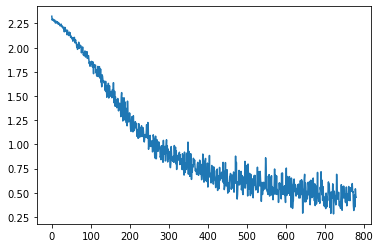

In [48]:
plt.plot(losses);

### Adam Gradient Descent

In [66]:
model = Mnist_NN().cuda()

In [67]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr) # an alternative is optim.SGD(model.parameters(), lr), which is what we did before.
    y_hat = model(x)
    loss = loss_func(y_hat, y) # loss_func = nn.CrossEntropyLoss()
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

Comparing this `update()` with the earlier one (logistic regression), you can see that this one uses more "PyTorch stuff" - i.e. their convienence functions. 

Specifically, there's this `Adam` thing. This is another way to perform gradient descent, implemented by PyTorch.

`wd` is handled internally, somewhere. Don't worry about it.

In [68]:
# Earlier, the lr is 2e-2. This is too big for Adam; our loss will diverge. So we decrease.
# You can try it yourself. Note that when you change learning rate to inspect differences, you have to retrain the model from
# scratch. If you do 2e-2 beforehand, the parameters are trained to be fked up. And if you lower lr to 1e-3 AND you train on
# top of it, it's not gonna change a thing, cos as I said, the parameters are too chaotic and is not going to come back.
# So, recreate the model: rerun model = Mnist_NN().cuda().

lr = 1e-3 
losses = [update(x, y, lr) for x,y in data.train_dl]

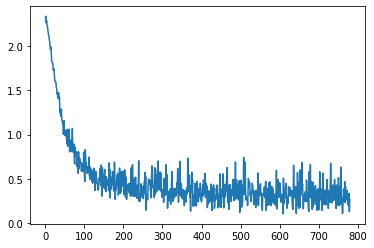

In [69]:
plt.plot(losses);

Compare this graph (ADAM) with the one earlier (basic SGD). Notice how in this one, the loss drops way faster, hovering around 0.5 in like 15% of the batches it took for the latter.

So, we can see how ADAM's momentum and exponentinally weighted moving average of the gradient (of the loss fn) sqaured can do a lot to adjust to adjust the parameters quickly s.t. the loss function is at a minimum quickly.

## Neural Network using Fastai 

TY - They also use Adam for gradient descent strategy, but with some possible minor tweaks. But main thing is: it's pretty much the same core implementation as the one we demonstrated (PyTorch framework) earlier, plus some more tuning. But this tuning that Fastai provides (in its `Learner` construct), it's actually offers a lot of yields.

In [75]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


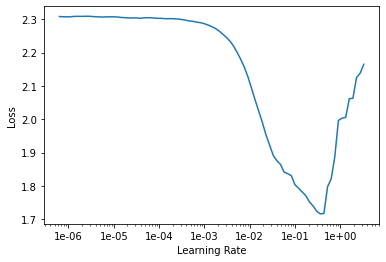

In [71]:
learn.lr_find()
learn.recorder.plot()

In [76]:
# From the lr_find() plot, we identify lr = 2e-02 to be good. Cos this is where the slope is the steepest (negatively).
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.144135,0.118151,0.964200,00:28


Look at our `valid_loss` by picking a suitable `lr`, and using Fastai's `Learner`'s `fit_one_cycle()`. It's 0.118. When we implemented it ourselves with PyTorch, we are hovering around 0.5 for loss. Fastai's `Learner` ftw.

### Just what is `fit_one_cycle()`?

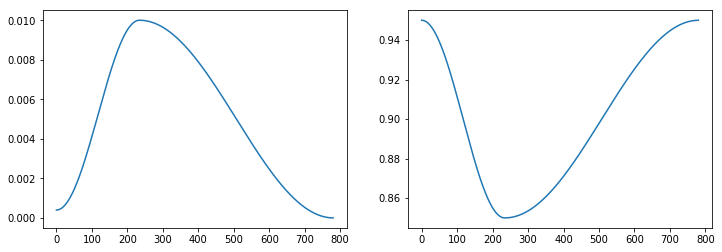

In [ ]:
learn.recorder.plot_lr(show_moms=True)

LHS is plot of learning rate against a particular batch within an epoch. It demonstrates learning rate annealing. 
- You can see that lr is low at the start of epoch. This is because parameter is initialised to be random, so the parameter space is wild with crazy gradients (bumpy). High lr at start is inadvisable as you will just get thrown around with no real progress.
- lr picks up as you move into space where things are less bumpy. And the slopes are more gentle, but they point in the direction that is indeed towards the minima. So lr is increased to reach there faster.
- Don't confuse _learning rate annealing_ with _learning rate discrimination_.
    - Annealing is to speed up convergence to minima. During annealing, lr varies.
    - Discrimination is wrt transfer learning. Earlier layer groups have lower lr than the last layer group. We do this because we start with a pre-trained model (e.g. ImageNet), and the earlier layer groups are tuned to do their jobs (and thus only need minor tweaks), save for the final layer which is untrained, and so necessitates a higher lr to mould the model to fit our needs. Compared to annealing, the lr does not vary within a particular layer group, but they vary spatially across the entire neural network (different layer groups). But temporally static.
    
RHS is plot of momentum across the same x-axis as LHS. It has the opposite r/s with learning rate. That is, when one is low, the other is high. Here's the explanation given:

"Because I do have a learning small learning rate, but you keep going in the same direction, you may as well go faster. But if you're jumping really far, don't like jump really far because it's going to throw you off. Then as you get to the end again, you're fine tuning in but actually if you keep going the same direction again and again, go faster. So this combination is called one cycle and it's a simple thing but it's astonishing. This can help you get what's called super convergence that can let you train 10 times faster."

Honestly, I cannot reconcile, intuitively, about the nuances of learning rate and momentum and how they affect the "jumping over the parameter space". __But the main thing is, this combo-wombo of the learning rate and momentum is `fit_one_cycle()` and it works.__

## fin